# Glucose and Insulin

In [ ]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    # url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    url = "https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/"
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [1]:
import numpy
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [3]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05
params = G0, k1, k2, k3

In [4]:
def make_system(params, data):
    G0, k1, k2, k3 = params
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    Gb = data.glucose[t_0]
    Ib = data.insulin[t_0]
    I = modsim.interpolate(data.insulin)
    
    init = modsim.State(G=G0, X=0) # only those that changes in time
    
    return modsim.System(
        init=init, params=params,
        Gb=Gb, Ib=Ib, I=I,
        t_0=t_0, t_end=t_end, dt=2,
)

In [7]:
data = pandas.read_csv('glucose_insulin.csv', index_col='time')
data.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


In [11]:
system = make_system(params, data)
modsim.show(system)

,value
init,"G 270 X 0 Name: state, dtype: int64"
params,"(270, 0.02, 0.02, 1.5e-05)"
Gb,92
Ib,11
I,<scipy.interpolate.interpolate.interp1d object...
t_0,0
t_end,182
dt,2


In [12]:
def update_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return modsim.State(G=G, X=X)

In [13]:
update_func(system.t_0, system.init, system)

G    262.88
X      0.00
Name: state, dtype: float64

In [15]:
def run_simulation(system, update_func):    
    t_array = modsim.linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    frame = modsim.TimeFrame(index=t_array, 
                             columns=system.init.index)
    frame.iloc[0] = system.init
    
    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(t, state, system)
    
    return frame

In [17]:
results = run_simulation(system, update_func)
results.head()


,G,X
0.0,270.000000,0.000000
2.0,262.880000,0.000000
4.0,256.044800,0.000450
6.0,249.252568,0.004002
8.0,240.967447,0.006062


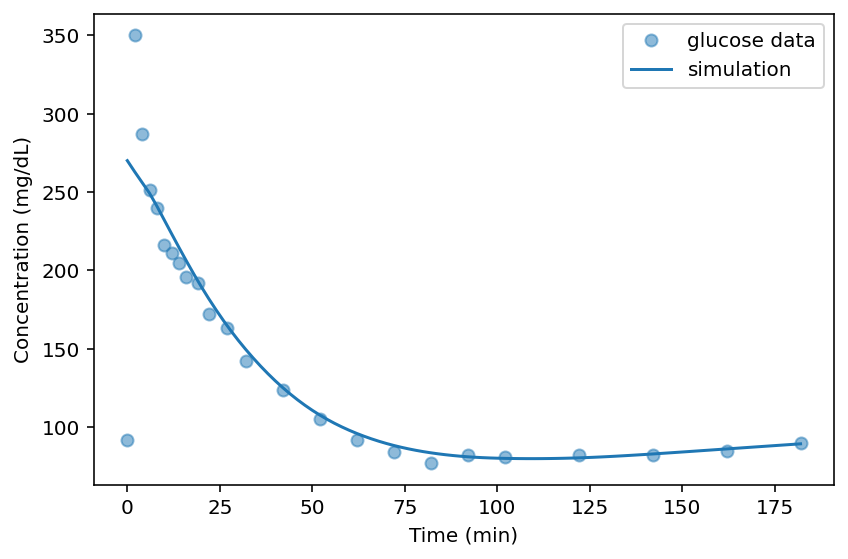

In [18]:
data.glucose.plot(style='o', alpha=0.5, label='glucose data')
results.G.plot(style='-', color='C0', label='simulation')

modsim.decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

The problem is that the model is non-spatial; that is, it does not take into account different concentrations in different parts of the body. Instead, it assumes that the concentrations of glucose and insulin in blood, and insulin in tissue fluid, are the same throughout the body. This way of representing the body is known among experts as the “bag of blood” model.

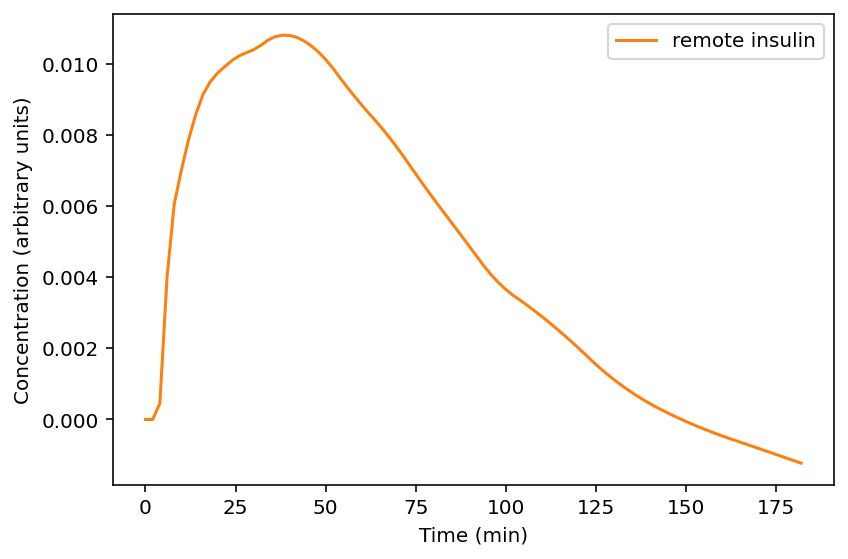

In [19]:
results.X.plot(color='C1', label='remote insulin')

modsim.decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

`X` rises quickly after the initial injection and then declines as the concentration of glucose declines. Qualitatively, this behavior is as expected, but because `X` is not an observable quantity, we can’t validate this part of the model quantitatively.

### Solving Differential Equations

In [20]:
def slope_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params 
    I, Ib, Gb = system.I, system.Ib, system.Gb
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

In [21]:
results2, details = modsim.run_solve_ivp(
    system, slope_func,
    t_eval=results.index,
)

In [22]:
details.success

True

In [23]:
details.message


'The solver successfully reached the end of the integration interval.'

In [24]:
results2.head()

,G,X
0.0,270.000000,0.000000
2.0,262.980942,0.000240
4.0,255.683455,0.002525
6.0,247.315442,0.005174
8.0,238.271851,0.006602


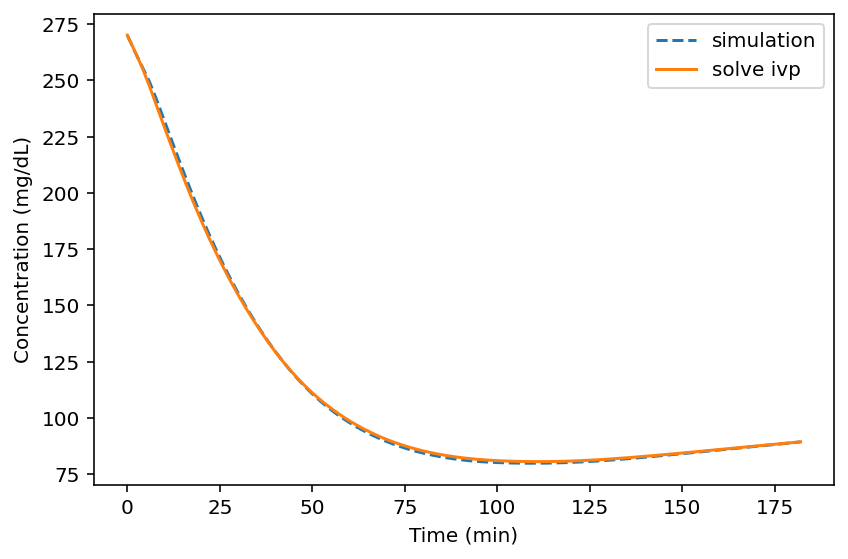

In [25]:
results.G.plot(style='--', label='simulation')
results2.G.plot(style='-', label='solve ivp')

modsim.decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [26]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100

In [27]:
percent_diff.abs().describe()

count    92.000000
mean      0.649121
std       0.392903
min       0.000000
25%       0.274854
50%       0.684262
75%       1.009868
max       1.278168
Name: G, dtype: float64

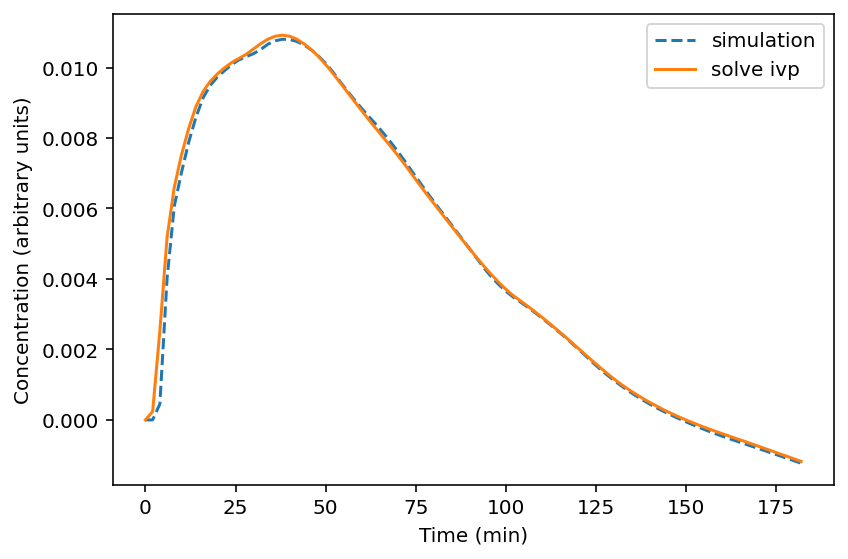

In [28]:
results.X.plot(style='--', label='simulation')
results2.X.plot(style='-', label='solve ivp')

modsim.decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

### Exercise 1
Our solution to the differential equations is only approximate because we used a finite step size, `dt=2` minutes. If we make the step size smaller, we expect the solution to be more accurate. Run the simulation with `dt=1` and compare the results. What is the largest relative error between the two solutions?

In [42]:
system3 = system.set(dt=1)
system3

namespace(init=G    270
               X      0
               Name: state, dtype: int64,
          params=(270, 0.02, 0.02, 1.5e-05),
          Gb=92,
          Ib=11,
          I=<scipy.interpolate.interpolate.interp1d at 0x11e3cd860>,
          t_0=0,
          t_end=182,
          dt=1)

In [48]:
results3 = run_simulation(system3, update_func)

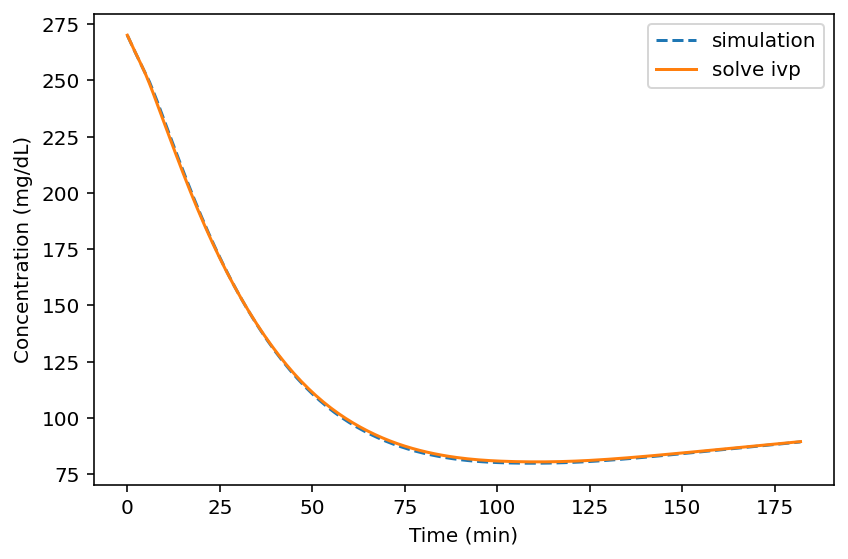

In [49]:
results.G.plot(style='--', label='simulation')
results3.G.plot(style='-', label='solve ivp')

modsim.decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [50]:
diff3 = results.G - results3.G
percent_diff3 = diff3 / results3.G * 100
percent_diff3.abs().describe()

count    92.000000
mean      0.527015
std       0.291531
min       0.000000
25%       0.292193
50%       0.505702
75%       0.801698
max       0.970760
Name: G, dtype: float64

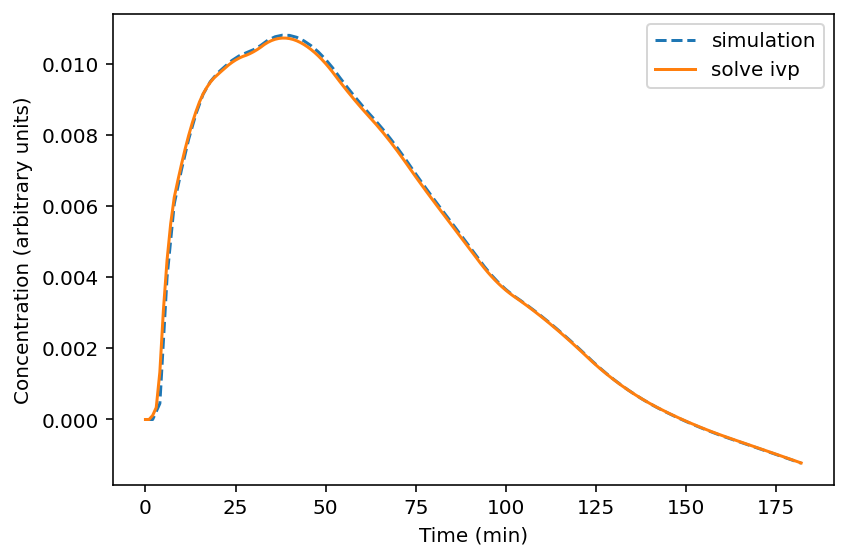

In [51]:
results.X.plot(style='--', label='simulation')
results3.X.plot(style='-', label='solve ivp')

modsim.decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')